In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import sqlite3
import random
import torch
import itertools
from tqdm import tqdm
import functools
from PIL import Image
from collections import defaultdict
from IPython.display import display, HTML
import base64
import io
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import get_scheduler
from torch import optim
import torch.nn as nn
import numpy as np
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
from models import ScoreClassifier, QualityClassifier
import psycopg
from pathlib import Path
from grid_models import NsfwClassifier as GridClassifier

In [4]:
model = QualityClassifier(768, 0.0)
model.load_state_dict(torch.load('classifier.pt'))
model.eval()

/tmp/ipykernel_615349/1550767548.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('classifier.pt'))


QualityClassifier(
  (ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (seq): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=1536, out_features=3072, bias=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=3072, out_features=2, bias=True)
  )
)

In [5]:
DATASET_SIZE = 4096 * 2

with psycopg.connect(dbname='postgres', user='postgres', host=str(Path.cwd().parent / "pg-socket")) as conn:
	cursor = conn.cursor()
	cursor.execute('SELECT path FROM images WHERE embedding IS NOT NULL')
	all_paths = [row[0] for row in cursor.fetchall()]
	random_paths = random.sample(all_paths, DATASET_SIZE)

	embeddings = {}
	for path in random_paths:
		cursor.execute('SELECT embedding FROM images WHERE path = %s', (path,))
		embedding = bytes(cursor.fetchone()[0])
		embedding = torch.frombuffer(embedding, dtype=torch.float16).to(torch.float32)
		embeddings[path] = embedding

#pairs = list(itertools.combinations(random_embeddings, 2))

/tmp/ipykernel_615349/3682615021.py:13: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789172399/work/torch/csrc/utils/tensor_new.cpp:1544.)
  embedding = torch.frombuffer(embedding, dtype=torch.float16).to(torch.float32)


In [6]:
# ELO
default_rating = 1500
k_factor = 10
ratings = {}
rounds = 2048 * 4

def expected_score(rating_a, rating_b):
	return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

def update_ratings(a, b, score_a):
	rating_a = ratings[a]
	rating_b = ratings[b]

	expected_a = expected_score(rating_a, rating_b)
	expected_b = expected_score(rating_b, rating_a)

	ratings[a] = rating_a + k_factor * (score_a - expected_a)
	ratings[b] = rating_b + k_factor * ((1 - score_a) - expected_b)


def random_derangement(lst: list) -> list:
	while True:
		v = [i for i in range(len(lst))]
		for j in range(len(lst) - 1, -1, -1):
			p = random.randint(0, j)
			if v[j] == lst[p]:
				break
			v[j], v[p] = v[p], v[j]
		else:
			if v[0] != lst[0]:
				return [lst[i] for i in v]


@torch.no_grad()
def do_round():
	pairs = list(zip(random_paths, random_derangement(random_paths)))
	embeddings_a = torch.stack([embeddings[a] for a, b in pairs])
	embeddings_b = torch.stack([embeddings[b] for a, b in pairs])
	scores = model(embeddings_a, embeddings_b)
	scores = torch.softmax(scores, dim=1)[:, 0].tolist()
	scores = [1.0 if score > 0.5 else 0.0 for score in scores]

	# Update ratings
	ratings_a = [ratings[a] for a, b in pairs]
	ratings_b = [ratings[b] for a, b in pairs]

	expected_a = [expected_score(rating_a, rating_b) for rating_a, rating_b in zip(ratings_a, ratings_b)]
	expected_b = [expected_score(rating_b, rating_a) for rating_a, rating_b in zip(ratings_a, ratings_b)]

	for i, (a, b) in enumerate(pairs):
		score = scores[i]
		rating_a = ratings_a[i]
		rating_b = ratings_b[i]

		ratings[a] = rating_a + k_factor * (score - expected_a[i])
		ratings[b] = rating_b + k_factor * ((1 - score) - expected_b[i])


# Add all the paths to the ratings
for path in random_paths:
	ratings[path] = default_rating

# Play rounds
for round in tqdm(range(rounds)):
	do_round()

  0%|          | 0/8192 [00:00<?, ?it/s]

100%|██████████| 8192/8192 [06:13<00:00, 21.95it/s]


In [7]:
# Save rankings
torch.save(ratings, 'elo_rankings.pt')

In [ ]:
old_ratings = ratings

In [ ]:
diffs = [abs(ratings[p] - old_ratings[p]) for p in random_paths]
print(sum(diffs) / len(diffs))
print(max(diffs))
print(min(diffs))

## Visualise the ELO rankings

In [ ]:
# Find images that are a grid, but scored above 0
rankings = torch.load('elo_rankings.pt')
min_ranking = min(rankings.values())
max_ranking = max(rankings.values())
NUM_BINS = 10
bin_size = (max_ranking - min_ranking) / NUM_BINS

rankings = {p: min(NUM_BINS - 1, int((r - min_ranking) / bin_size)) for p, r in rankings.items()}
rankings = list((p, r) for p, r in rankings.items())

failures = []
total_grids = 0

# Use trained classifier to score images
with psycopg.connect(dbname='postgres', user='postgres', host=str(Path.cwd().parent / "pg-socket")) as conn:
	cursor = conn.cursor()

	grid_model = GridClassifier(768, 0.0, 2)
	grid_model.load_state_dict(torch.load('../grid-detector/classifier.pt'))
	grid_model.eval()

	for path, rank in tqdm(rankings, desc='Classifying grid images'):
		cursor.execute('SELECT embedding FROM images WHERE path = %s', (path,))
		embedding = bytes(cursor.fetchone()[0])
		embedding = torch.frombuffer(bytearray(embedding), dtype=torch.float16)
		embedding = embedding.to(torch.float32)
		embedding = embedding.unsqueeze(0)

		logits = grid_model(embedding)
		probabilities = F.softmax(logits, dim=1)

		is_grid = probabilities[:, 1].item() > 0.5

		if is_grid and rank > 0:
			failures.append((path, rank))
		
		total_grids += is_grid

print(f"Found {len(failures)} grid images with a rank above 0, out of {total_grids} total grid images")

for path, rank in failures[:10]:
	print(path, rank)
	image = Image.open(path)
	scale = 256 / max(image.width, image.height)
	image = image.resize((int(image.width * scale), int(image.height * scale)))
	display(image)

In [ ]:
rankings = torch.load('elo_rankings.pt')
min_ranking = min(rankings.values())
max_ranking = max(rankings.values())
NUM_BINS = 10
bin_size = (max_ranking - min_ranking) / NUM_BINS

rankings = {p: min(NUM_BINS - 1, int((r - min_ranking) / bin_size)) for p, r in rankings.items()}
rankings = list(rankings.items())


def img_html(path):
	image = Image.open(path)
	scale = 512 / max(image.size)
	image = image.resize((int(image.width * scale), int(image.height * scale)))
	image_base64 = io.BytesIO()
	image.save(image_base64, format='WebP', quality=80)
	image_base64 = base64.b64encode(image_base64.getvalue()).decode('utf-8')
	return f'<img src="data:image/webp;base64,{image_base64}" width="512" style="margin: 5px;">'

html = ""

for bin_number in range(NUM_BINS):
	images = [path for path, bin in rankings if bin == bin_number]
	images = random.sample(images, 16)

	html += f"<h1>Bin {bin_number}</h1>"
	#html += "<div style='display: flex; flex-wrap: wrap;'>"
	for path in images:
		html += img_html(path)
	#html += "</div>"
	html += "<hr>"


display(HTML(html))

## Train the model

In [10]:
class RankingDataset(torch.utils.data.Dataset):
	def __init__(self, data):
		self.data = data

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		return self.data[idx]


rankings = torch.load('elo_rankings.pt')
min_ranking = min(rankings.values())
max_ranking = max(rankings.values())
NUM_BINS = 10
bin_size = (max_ranking - min_ranking) / NUM_BINS

with psycopg.connect(dbname='postgres', user='postgres', host=str(Path.cwd().parent / "pg-socket")) as conn:
	cursor = conn.cursor()

	embeddings = {}
	for path in rankings.keys():
		cursor.execute('SELECT embedding FROM images WHERE path = %s', (path,))
		embedding = bytes(cursor.fetchone()[0])
		embedding = torch.frombuffer(embedding, dtype=torch.float16).to(torch.float32)
		embeddings[path] = embedding

rankings = {p: min(NUM_BINS - 1, int((r - min_ranking) / bin_size)) for p, r in rankings.items()}

data = [(embeddings[p], rank) for p, rank in rankings.items()]
random.shuffle(data)
test_size = len(data) // 10
train_data = data[:-test_size]
test_data = data[-test_size:]

train_dataset = RankingDataset(train_data)
test_dataset = RankingDataset(test_data)

print(len(train_dataset), len(test_dataset))

/tmp/ipykernel_615349/1113081306.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rankings = torch.load('elo_rankings.pt')


7373 819


In [11]:
BATCH_SIZE = 512

train_dataloader = DataLoader(
	dataset=train_dataset,
	batch_size=BATCH_SIZE,
	shuffle=True,
)

test_dataloader = DataLoader(
	dataset=test_dataset,
	batch_size=BATCH_SIZE,
	shuffle=False,
)

## LR Finder

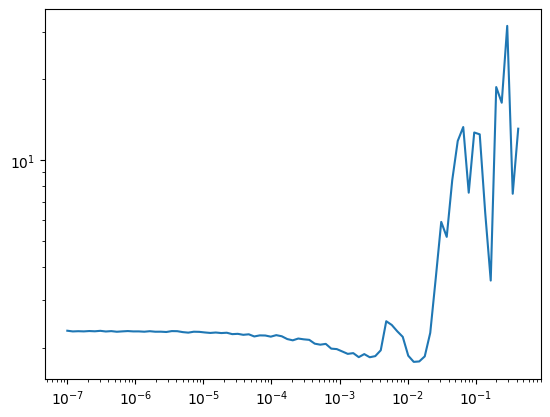

In [13]:
def lr_finder(
	dropout: float,
	weight_decay: float,
	start_lr: float = 1e-7,
	end_lr: float = 10,
	num_it: int = 100,
	beta: float = 0.98,
):
	learning_rates = np.geomspace(start_lr, end_lr, num_it)
	model = ScoreClassifier(768, dropout=dropout, bins=NUM_BINS).to('cuda')

	loss_function = nn.CrossEntropyLoss()
	optimizer = optim.AdamW(model.parameters(), lr=1.0, weight_decay=weight_decay)

	dataset_iter = iter(train_dataloader)
	training_losses = []
	training_lrs = []
	smooth_loss = None
	avg_loss = None
	best_loss = 1000000000

	for lr in learning_rates:
		# Set learning rate
		for param_group in optimizer.param_groups:
			param_group['lr'] = lr

		# Get batch
		try:
			x, y = next(dataset_iter)
		except StopIteration:
			dataset_iter = iter(train_dataloader)
			x, y = next(dataset_iter)
		
		x = x.to('cuda')
		y = y.to('cuda')
		
		# Train
		model.train()
		output = model(x)
		loss = loss_function(output, y)
		optimizer.zero_grad(set_to_none=True)
		loss.backward()
		optimizer.step()

		training_losses.append(loss.item())
		training_lrs.append(lr)

		if avg_loss is None:
			avg_loss = loss
		else:
			avg_loss = beta * avg_loss + (1 - beta) * loss
		
		smooth_loss = avg_loss / (1 - beta ** (len(training_losses) + 1))
		
		best_loss = min(best_loss, smooth_loss)

		if smooth_loss > 4 * best_loss or torch.isnan(smooth_loss):
			break
	
	return {
		"training_losses": training_losses,
		"training_lrs": training_lrs,
	}


results = lr_finder(
	dropout=0.1,
	weight_decay=0.1,
)

plt.plot(results['training_lrs'][:-2], results['training_losses'][:-2])
plt.xscale('log')
plt.yscale('log')
plt.show()

## Train

In [12]:
@torch.no_grad()
def test(model, dataloader: DataLoader, loss_function) -> tuple[float, float]:
	model.eval()

	corrects = []
	loss_sum = torch.zeros(1, dtype=torch.float32, device='cpu', requires_grad=False)

	for x, y in dataloader:
		x = x.to('cuda')
		y = y.to('cuda')
		output = model(x)
		loss = loss_function(output, y)
		loss_sum.add_(loss.detach().cpu())
		probs = F.softmax(output, dim=1)
		predictions = torch.argmax(probs, dim=1)
		correct = (predictions == y).tolist()
		corrects.extend(correct)
	
	mean_loss = loss_sum / len(dataloader)
	return sum(corrects) / len(corrects), mean_loss.item()


def train_a_model(
	learning_rate: float,
	dropout: float,
	warmup_samples: int,
	training_samples: int,
	test_every: int,
	weight_decay: float,
	one_cycle: bool,
):
	model = ScoreClassifier(768, dropout=dropout, bins=NUM_BINS).to('cuda')

	warmup_steps = warmup_samples // BATCH_SIZE
	training_steps = max(1, training_samples // BATCH_SIZE)
	test_every_steps = max(1, test_every // BATCH_SIZE)

	loss_function = nn.CrossEntropyLoss()
	optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
	if one_cycle:
		lr_scheduler = OneCycleLR(
			optimizer=optimizer,
			max_lr=learning_rate,
			total_steps=training_steps,
		)
	else:
		lr_scheduler = get_scheduler(
			name="cosine",
			optimizer=optimizer,
			num_warmup_steps=warmup_steps,
			num_training_steps=training_steps,
		)

	#test_before, test_loss_before = test(model, test_dataloader, loss_function)
	#print(f"Test accuracy before training: {test_before}")
	#print(f"Test loss before training: {test_loss_before}")

	dataset_iter = iter(train_dataloader)
	training_losses = []
	training_lrs = []
	test_losses = []
	test_accuracies = []

	for step in range(training_steps):
		# Get batch
		try:
			x, y = next(dataset_iter)
		except StopIteration:
			dataset_iter = iter(train_dataloader)
			x, y = next(dataset_iter)
		
		x = x.to('cuda')
		y = y.to('cuda')
		
		# Train
		model.train()
		output = model(x)
		loss = loss_function(output, y)
		optimizer.zero_grad(set_to_none=True)
		loss.backward()
		optimizer.step()
		lr_scheduler.step()

		# Test
		if step % test_every_steps == 0:
			test_acc, test_loss = test(model, test_dataloader, loss_function)
			test_losses.append(test_loss)
			test_accuracies.append(test_acc)
		
		training_losses.append(loss.item())
		training_lrs.append(lr_scheduler.get_last_lr()[0])
	
	return {
		"training_losses": training_losses,
		"training_lrs": training_lrs,
		"test_losses": test_losses,
		"test_accuracies": test_accuracies,
		"model": model,
	}

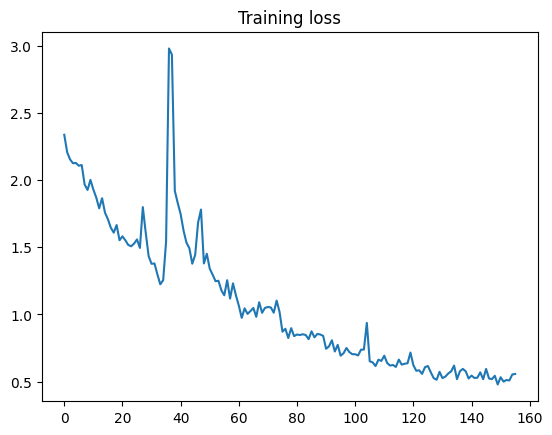

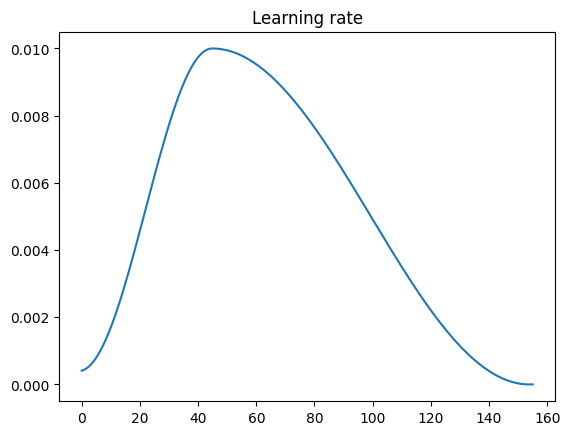

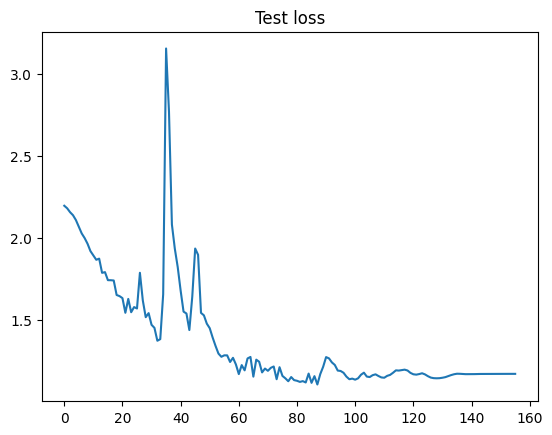

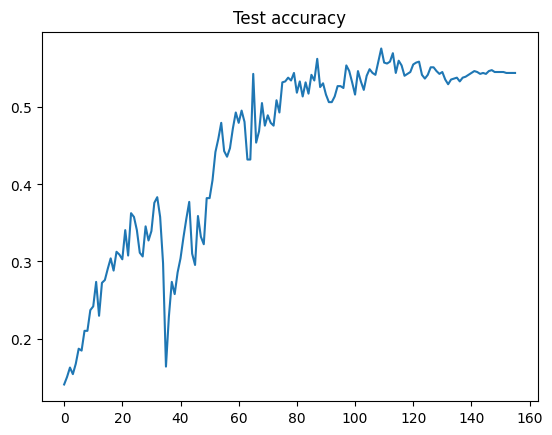

Test loss: 1.1716612577438354
Test accuracy: 0.5445665445665445


In [18]:
result = train_a_model(
	learning_rate=1e-2,
	dropout=0.1,
	warmup_samples=1000,
	training_samples=80000,
	test_every=512,
	weight_decay=0.1,
	one_cycle=True
)

min_test_loss = result["test_losses"][-1]
min_test_accuracy = result["test_accuracies"][-1]


plt.plot(result['training_losses'])
plt.title('Training loss')
plt.show()

plt.plot(result['training_lrs'])
plt.title('Learning rate')
plt.show()

plt.plot(result['test_losses'])
plt.title('Test loss')
plt.show()

plt.plot(result['test_accuracies'])
plt.title('Test accuracy')
plt.show()

print(f"Test loss: {min_test_loss}")
print(f"Test accuracy: {min_test_accuracy}")

best_model = result

In [19]:
torch.save(best_model['model'].state_dict(), "scorer.pt")

In [ ]:
# ELO
default_rating = 1500
k_factor = 10
ratings = {}
rounds = 512

def expected_score(rating_a, rating_b):
	return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

def update_ratings(a, b, score_a):
	rating_a = ratings[a]
	rating_b = ratings[b]

	expected_a = expected_score(rating_a, rating_b)
	expected_b = expected_score(rating_b, rating_a)

	ratings[a] = rating_a + k_factor * (score_a - expected_a)
	ratings[b] = rating_b + k_factor * ((1 - score_a) - expected_b)


# Add all the paths to the ratings
for path in random_paths:
	ratings[path] = default_rating

# Play rounds
with torch.no_grad():
	for round in tqdm(range(rounds)):
		for a in random_paths:
			while True:
				b = random.choice(random_paths)
				if a != b:
					break
			
			embedding_a = embeddings[a]
			embedding_b = embeddings[b]
			score = model(embedding_a.unsqueeze(0), embedding_b.unsqueeze(0))[0]
			score = torch.softmax(score, dim=0)[0].item()
			score = 1.0 if score > 0.5 else 0.0
			update_ratings(a, b, score)

In [ ]:
# Graph the histogram of ratings
import matplotlib.pyplot as plt

plt.hist(ratings.values(), bins=20)
plt.show()

print(min(ratings.values()))
print(max(ratings.values()))

In [ ]:
NUM_BINS = 10
max_rating = max(ratings.values())
min_rating = min(ratings.values())
bin_size = (max_rating - min_rating) / NUM_BINS
bins = defaultdict(list)

for path in random_paths:
	rank = ratings[path]
	bin = min(int((rank - min_rating) / bin_size), NUM_BINS - 1)
	bins[bin].append(path)

print("Bin sizes:")
print(", ".join(f"{len(bin)}" for bin in bins.values()))

def img_html(path):
	image = Image.open(path)
	scale = 512 / max(image.size)
	image = image.resize((int(image.width * scale), int(image.height * scale)))
	image_base64 = io.BytesIO()
	image.save(image_base64, format='WebP', quality=80)
	image_base64 = base64.b64encode(image_base64.getvalue()).decode('utf-8')
	return f'<img src="data:image/webp;base64,{image_base64}" width="512" style="margin: 5px;">'

html = "<table>"

for bin_number, image_paths in bins.items():
	sampled_images = random.sample(image_paths, 5)

	row_html = f"<tr><td>{bin_number}</td>"
	for path in sampled_images:
		row_html += f"<td>{img_html(path)}</td>"
	row_html += "</tr>"

	html += row_html

html += "</table>"

display(HTML(html))

#for path in sorted_paths[::10]:
#	print(ratings[path])
#	image = Image.open(path)
#	scale = 256 / max(image.size)
#	display(image.resize((int(image.width * scale), int(image.height * scale))))

In [ ]:
sort_cache = {}

def sort_func(a, b):
	flipped = False
	if b < a:
		a, b = b, a
		flipped = True
	
	if (a, b) in sort_cache:
		return sort_cache[(a, b)] if not flipped else -sort_cache[(a, b)]

	a_embedding = embeddings[a].unsqueeze(0)
	b_embedding = embeddings[b].unsqueeze(0)
	if a == b or torch.allclose(a_embedding, b_embedding):
		return 0
	
	score = model(a_embedding, b_embedding)[0]
	score = torch.softmax(score, dim=0)[0].item()
	score = -1 if score < 0.5 else 1
	sort_cache[(a, b)] = score
	score = -score if flipped else score

	return score

sorted_paths = sorted(random_paths, key=functools.cmp_to_key(sort_func))
print(f"Performed {len(sort_cache)} comparisons")

In [ ]:
for path in sorted_paths:
	image = Image.open(path)
	scale = 512 / max(image.size)
	display(image.resize((int(image.width * scale), int(image.height * scale))))

In [ ]:
for i in range(len(sorted_paths)-1):
	a = sorted_paths[i]
	b = sorted_paths[i+1]
	embedding_a = embeddings[a]
	embedding_b = embeddings[b]
	score = model(embedding_a.unsqueeze(0), embedding_b.unsqueeze(0))[0]
	score = torch.softmax(score, dim=0)[0].item()
	print(score)